In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Conv1D, MaxPool1D, GlobalMaxPool1D, Embedding, Activation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.optimizers import Adam
import nltk 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from nltk.probability import FreqDist
import collections
import string

In [3]:
import gensim
from gensim.models.word2vec import Word2Vec

In [4]:
 # Read In Data and Format It Better
df = pd.read_csv('spam.csv', sep=',', encoding='ISO-8859-1')
df = df.drop(columns=[ "Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df.head(5)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
  # Add 2 New Columns: For binary spam/ham indicator and length of message
df['Result']= df['v1'].map( {'spam' : int(1), 'ham' : int(0)})
df['Message_Size'] = df['v2'].apply(len)
df.head(5)

,v1,v2,Result,Message_Size
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


In [6]:
 # Calculate Statistics
totalMessages = df['Result'].count()
numSpams = df[df['Result']==1]['Result'].count()
numValid = df[df['Result'] == 0]['Result'].count()
# Print Distribution
print(f'{numSpams} of {totalMessages} messages are spam: {((numSpams/totalMessages)*100)}%')

747 of 5572 messages are spam: 13.406317300789663%


In [7]:
nltk.download('punkt')
# Tokenize Each Message and add the list of tokens to the DataFrame
df['Tokens'] = df['v2'].apply(word_tokenize)
df.head(5)

[nltk_data] Downloading package punkt to /Users/yingqiu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,v1,v2,Result,Message_Size,Tokens
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,"[Go, until, jurong, point, ,, crazy, .., Avail..."
1,ham,Ok lar... Joking wif u oni...,0,29,"[Ok, lar, ..., Joking, wif, u, oni, ...]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F..."
3,ham,U dun say so early hor... U c already then say...,0,49,"[U, dun, say, so, early, hor, ..., U, c, alrea..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,"[Nah, I, do, n't, think, he, goes, to, usf, ,,..."


In [8]:
special_words = ['...']

In [9]:
def eliminateStop(words):
# Remove stopwords
    words = [w for w in words if not w in stop_words]
# Remove special words
    words = [w for w in words if not w in special_words]
# Remove single-character tokens (mostly punctuation)
    words = [word for word in words if len(word) > 1]
# Lowercase all words (default_stopwords are lowercase too)
    returnList = [word.lower() for word in words]
    return returnList

In [10]:
nltk.download('stopwords')
# Add Tokenize With Removed Stop Words
stop_words = set(stopwords.words("english"))
df['Filtered_Tokens'] = df['Tokens'].apply(eliminateStop)
df.head(5)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yingqiu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,v1,v2,Result,Message_Size,Tokens,Filtered_Tokens
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,"[Go, until, jurong, point, ,, crazy, .., Avail...","[go, jurong, point, crazy, .., available, bugi..."
1,ham,Ok lar... Joking wif u oni...,0,29,"[Ok, lar, ..., Joking, wif, u, oni, ...]","[ok, lar, joking, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,0,49,"[U, dun, say, so, early, hor, ..., U, c, alrea...","[dun, say, early, hor, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,"[Nah, I, do, n't, think, he, goes, to, usf, ,,...","[nah, n't, think, goes, usf, lives, around, th..."


In [11]:
#find the 20 most common words used in spam SMS
df_spam = df.loc[df['v1'] == 'spam']
list_all_spam = df_spam['Filtered_Tokens'].tolist()
list_all_spam = [words for sublist in list_all_spam for words in sublist]

fdist = nltk.FreqDist(list_all_spam)
word_most_common_spam =[]
for word, frequency in fdist.most_common(20):
    word_most_common_spam.append(word)
    print(u'{};{}'.format(word, frequency))

call;346
free;219
txt;156
ur;144
mobile;123
text;121
stop;114
claim;113
you;107
reply;104
prize;92
get;84
to;79
your;76
's;72
new;69
send;68
nokia;65
cash;62
urgent;62


In [12]:
#find the 20 most common words used in ham SMS
df_ham = df.loc[df['v1'] == 'ham']
list_all_ham = df_ham['Filtered_Tokens'].tolist()
list_all_ham = [words for sublist in list_all_ham for words in sublist]

fdist = nltk.FreqDist(list_all_ham)
word_most_common_ham =[]
for word, frequency in fdist.most_common(20):
    word_most_common_ham.append(word)
    print(u'{};{}'.format(word, frequency))

..;669
's;422
'm;387
n't;346
gt;318
lt;316
get;301
'';264
ok;256
go;248
got;242
ur;237
know;236
you;233
like;231
call;230
good;229
'll;228
come;227
time;197


In [13]:
word_token = []
for i in df['Filtered_Tokens']:
    word_token.append(i)
print(word_token[: 2])

[['go', 'jurong', 'point', 'crazy', '..', 'available', 'bugis', 'great', 'world', 'la', 'buffet', 'cine', 'got', 'amore', 'wat'], ['ok', 'lar', 'joking', 'wif', 'oni']]


In [14]:
word2vec_model = Word2Vec(word_token, size=500, window=3, min_count=1, workers=16)
print(word2vec_model)

Word2Vec(vocab=9362, size=500, alpha=0.025)


In [15]:
token = Tokenizer(9362)
token.fit_on_texts(df['Filtered_Tokens'])
text = token.texts_to_sequences(df['Filtered_Tokens'])
text = pad_sequences(text, 75)
print(text[:2])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0   12 4370  738  694    1  589 1201   69  252 1202
  2866 1203   16 4371   76]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
    14  253 1547  376 1801]]


In [16]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(df['Result'])
y = to_categorical(y)
y[:2]

array([[1., 0.],
       [1., 0.]], dtype=float32)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(np.array(text), y, test_size=0.2, stratify=y)

In [19]:
keras_model = Sequential()
keras_model.add(word2vec_model.wv.get_keras_embedding(True))
keras_model.add(Dropout(0.2))
keras_model.add(Conv1D(50, 3, activation='relu', padding='same', strides=1))
keras_model.add(Conv1D(50, 3, activation='relu', padding='same', strides=1))
keras_model.add(MaxPool1D())
keras_model.add(Dropout(0.2))
keras_model.add(Conv1D(100, 3, activation='relu', padding='same', strides=1))
keras_model.add(Conv1D(100, 3, activation='relu', padding='same', strides=1))
keras_model.add(MaxPool1D())
keras_model.add(Dropout(0.2))
keras_model.add(Conv1D(200, 3, activation='relu', padding='same', strides=1))
keras_model.add(Conv1D(200, 3, activation='relu', padding='same', strides=1))
keras_model.add(GlobalMaxPool1D())
keras_model.add(Dropout(0.2))
keras_model.add(Dense(200))
keras_model.add(Activation('relu'))
keras_model.add(Dropout(0.2))
keras_model.add(Dense(2))
keras_model.add(Activation('softmax'))
adam = Adam(lr=1e-4)
keras_model.compile(loss='binary_crossentropy', metrics=['acc'], optimizer= adam)
keras_model.fit(x_train, y_train, batch_size=16, epochs=3, validation_data=(x_test, y_test))

Epoch 1/3
279/279 [==============================] - 16s 58ms/step - loss: 0.4092 - acc: 0.8618 - val_loss: 0.4302 - val_acc: 0.8664
Epoch 2/3
279/279 [==============================] - 17s 59ms/step - loss: 0.3296 - acc: 0.8717 - val_loss: 0.1606 - val_acc: 0.9650
Epoch 3/3
279/279 [==============================] - 16s 57ms/step - loss: 0.0905 - acc: 0.9733 - val_loss: 0.0491 - val_acc: 0.9865


## Another way to tokenize the text

In [20]:
#print(string.punctuation)
table = str.maketrans('', '', string.punctuation)
def TextSplit(text):
    text_split = text.split()
    stripped = [w.translate(table) for w in text_split]
    return stripped

df['Token2']=df['v2'].apply(TextSplit)
df.head(5)

,v1,v2,Result,Message_Size,Tokens,Filtered_Tokens,Token2
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,"[Go, until, jurong, point, ,, crazy, .., Avail...","[go, jurong, point, crazy, .., available, bugi...","[Go, until, jurong, point, crazy, Available, o..."
1,ham,Ok lar... Joking wif u oni...,0,29,"[Ok, lar, ..., Joking, wif, u, oni, ...]","[ok, lar, joking, wif, oni]","[Ok, lar, Joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...","[free, entry, wkly, comp, win, fa, cup, final,...","[Free, entry, in, 2, a, wkly, comp, to, win, F..."
3,ham,U dun say so early hor... U c already then say...,0,49,"[U, dun, say, so, early, hor, ..., U, c, alrea...","[dun, say, early, hor, already, say]","[U, dun, say, so, early, hor, U, c, already, t..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,"[Nah, I, do, n't, think, he, goes, to, usf, ,,...","[nah, n't, think, goes, usf, lives, around, th...","[Nah, I, dont, think, he, goes, to, usf, he, l..."


In [21]:
def eliminateStop(words):
# Remove stopwords
    words = [w for w in words if not w in stop_words]
# Remove special words
    words = [w for w in words if not w in special_words]
# Remove single-character tokens (mostly punctuation)
    words = [word for word in words if len(word) > 1]
# Lowercase all words (default_stopwords are lowercase too)
    returnList = [word.lower() for word in words]
    return returnList

In [22]:
df['Filtered_Tokens_2'] = df['Token2'].apply(eliminateStop)
df.head(5)

,v1,v2,Result,Message_Size,Tokens,Filtered_Tokens,Token2,Filtered_Tokens_2
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,"[Go, until, jurong, point, ,, crazy, .., Avail...","[go, jurong, point, crazy, .., available, bugi...","[Go, until, jurong, point, crazy, Available, o...","[go, jurong, point, crazy, available, bugis, g..."
1,ham,Ok lar... Joking wif u oni...,0,29,"[Ok, lar, ..., Joking, wif, u, oni, ...]","[ok, lar, joking, wif, oni]","[Ok, lar, Joking, wif, u, oni]","[ok, lar, joking, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...","[free, entry, wkly, comp, win, fa, cup, final,...","[Free, entry, in, 2, a, wkly, comp, to, win, F...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,0,49,"[U, dun, say, so, early, hor, ..., U, c, alrea...","[dun, say, early, hor, already, say]","[U, dun, say, so, early, hor, U, c, already, t...","[dun, say, early, hor, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,"[Nah, I, do, n't, think, he, goes, to, usf, ,,...","[nah, n't, think, goes, usf, lives, around, th...","[Nah, I, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t..."


In [23]:
#find the 50 most common words used in spam SMS
df_spam = df.loc[df['v1'] == 'spam']
list_all_spam = df_spam['Filtered_Tokens_2'].tolist()
list_all_spam = [words for sublist in list_all_spam for words in sublist]

fdist = nltk.FreqDist(list_all_spam)
word_most_common_spam =[]
for word, frequency in fdist.most_common(50):
    word_most_common_spam.append(word)
    print(u'{};{}'.format(word, frequency))

call;347
free;216
txt;150
ur;144
mobile;123
text;120
claim;113
stop;113
you;102
reply;101
prize;92
get;83
to;78
your;76
new;69
send;67
nokia;65
urgent;63
cash;62
win;60
now;58
contact;56
service;55
please;52
guaranteed;50
customer;49
16;49
week;49
tone;48
per;46
phone;45
18;43
chat;42
no;41
this;41
awarded;38
draw;38
latest;36
we;36
å£1000;35
line;35
150ppm;34
mins;34
receive;33
camera;33
for;33
every;33
message;32
holiday;32
landline;32


In [24]:
#find the 50 most common words used in ham SMS
df_ham = df.loc[df['v1'] == 'ham']
list_all_ham = df_ham['Filtered_Tokens_2'].tolist()
list_all_ham = [words for sublist in list_all_ham for words in sublist]

fdist = nltk.FreqDist(list_all_ham)
word_most_common_ham =[]
for word, frequency in fdist.most_common(50):
    word_most_common_ham.append(word)
    print(u'{};{}'.format(word, frequency))

im;449
get;303
ltgt;276
ok;272
dont;257
go;247
ur;240
ill;236
know;232
got;231
like;229
call;229
come;224
good;222
you;213
time;189
day;187
love;185
going;167
want;163
one;162
home;160
lor;160
need;156
sorry;153
still;146
how;143
no;142
but;140
see;137
later;134
da;131
back;129
if;129
think;128
so;128
well;126
today;125
send;123
my;123
its;122
tell;121
cant;118
hi;117
take;112
much;112
oh;111
do;109
what;108
and;108


In [25]:
word_token_2 = []
for i in df['Filtered_Tokens_2']:
    word_token_2.append(i)
print(word_token_2[: 2])

[['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'great', 'world', 'la', 'buffet', 'cine', 'got', 'amore', 'wat'], ['ok', 'lar', 'joking', 'wif', 'oni']]


In [26]:
word2vec_model_2 = Word2Vec(word_token_2, size=500, window=3, min_count=1, workers=16)
print(word2vec_model_2)

Word2Vec(vocab=9510, size=500, alpha=0.025)


### Visulize the word embedding

/Users/yingqiu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yingqiu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


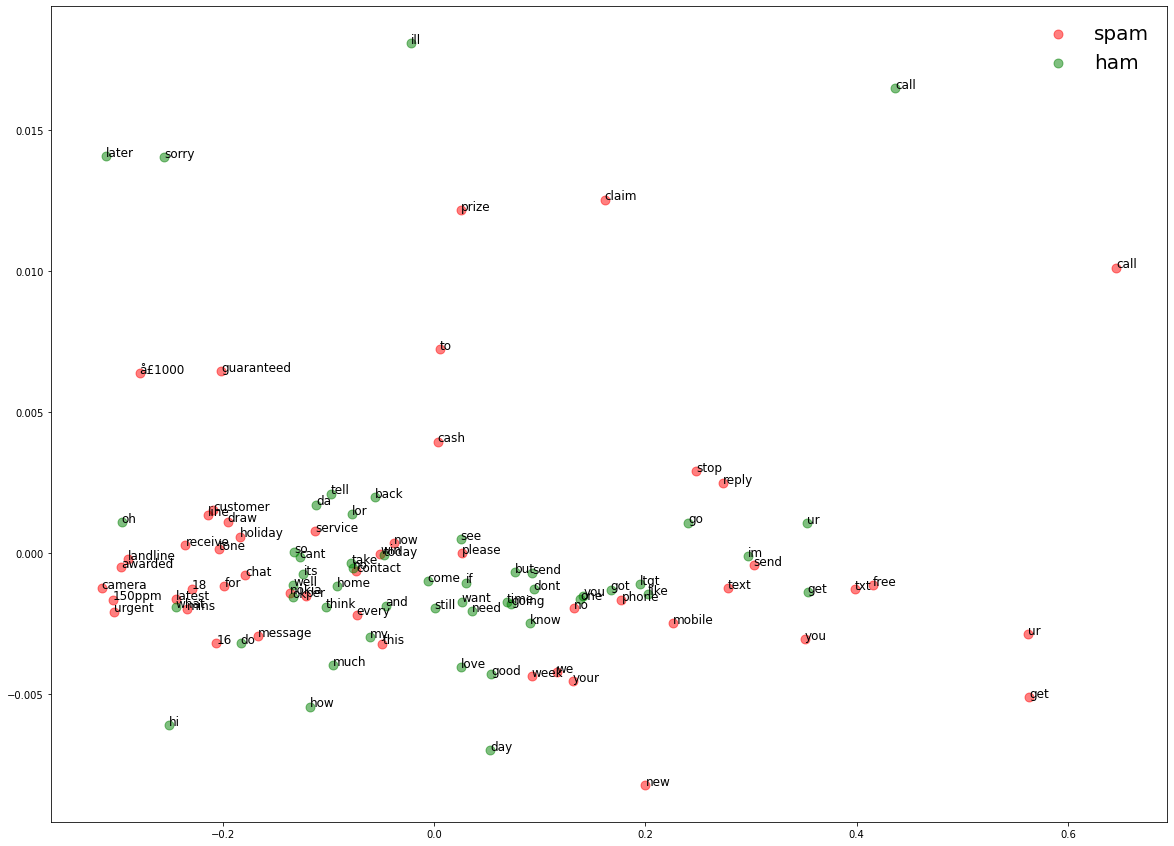

In [27]:
from sklearn.decomposition import PCA
from matplotlib import pyplot
X = word2vec_model_2[word_most_common_spam]
M = word2vec_model_2[word_most_common_ham]
pca = PCA(n_components=2)
result_X = pca.fit_transform(X)
result_M = pca.fit_transform(M)
# create a scatter plot of the projection
N=50
colors = np.random.rand(N)
plt.figure(figsize=(20, 15))
plt.scatter(result_X[:, 0], result_X[:, 1], s=80, c='r', alpha=0.5, marker='o',label = 'spam')
plt.scatter(result_M[:, 0], result_M[:, 1], s=80, c='g', alpha=0.5, marker='o',label = 'ham')
#plt.xlabel("TBD")
#plt.ylabel("TBD")
plt.legend(loc='upper right',frameon = False, fontsize = 20)

words_X = list(word_most_common_spam)
for i, word in enumerate(words_X):
    pyplot.annotate(word, xy=(result_X[i, 0], result_X[i, 1]),fontsize=12)
    
words_M = list(word_most_common_ham)
for i, word in enumerate(words_M):
    pyplot.annotate(word, xy=(result_M[i, 0], result_M[i, 1]),fontsize=12)
pyplot.savefig('most common words distribution.png')    
pyplot.show()

### reference: https://www.kaggle.com/jagannathrk/word2vec-cnn-text-classification